In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [178]:
user = pd.read_csv('user_table.csv')
test = pd.read_csv('test_table.csv')

In [179]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452867 entries, 0 to 452866
Data columns (total 4 columns):
user_id    452867 non-null int64
sex        452867 non-null object
age        452867 non-null int64
country    452867 non-null object
dtypes: int64(2), object(2)
memory usage: 13.8+ MB


This table has no missing values.

In [180]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453321 entries, 0 to 453320
Data columns (total 9 columns):
user_id             453321 non-null int64
date                453321 non-null object
source              453321 non-null object
device              453321 non-null object
browser_language    453321 non-null object
ads_channel         181877 non-null object
browser             453321 non-null object
conversion          453321 non-null int64
test                453321 non-null int64
dtypes: int64(3), object(6)
memory usage: 31.1+ MB


There are missing values in the ads_Channel. We need to take care of them later.

### Concatinate 2 tables

In [181]:
# We join the two tables by user_id.
dat = pd.merge(test, user, how = 'outer', on = 'user_id')

In [182]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 453321 entries, 0 to 453320
Data columns (total 12 columns):
user_id             453321 non-null int64
date                453321 non-null object
source              453321 non-null object
device              453321 non-null object
browser_language    453321 non-null object
ads_channel         181877 non-null object
browser             453321 non-null object
conversion          453321 non-null int64
test                453321 non-null int64
sex                 452867 non-null object
age                 452867 non-null float64
country             452867 non-null object
dtypes: float64(1), int64(3), object(8)
memory usage: 45.0+ MB


We have quite many Nan values on ads_channel and some Nan values related to user infomation (sex, age, country)

In [183]:
dat.head()

user_id        date  source  device browser_language ads_channel  \
0   315281  2015-12-03  Direct     Web               ES         NaN   
1   497851  2015-12-04     Ads     Web               ES      Google   
2   848402  2015-12-04     Ads     Web               ES    Facebook   
3   290051  2015-12-03     Ads  Mobile            Other    Facebook   
4   548435  2015-11-30     Ads     Web               ES      Google   

       browser  conversion  test sex   age country  
0           IE           1     0   M  32.0   Spain  
1           IE           0     1   M  21.0  Mexico  
2       Chrome           0     0   M  34.0   Spain  
3  Android_App           0     1   F  22.0  Mexico  
4      FireFox           0     1   M  19.0  Mexico

## Explore the data - Decise how to clean it

In [184]:
dat.groupby('test').size().to_frame()

0
test        
0     237338
1     215983

Verify that the number of test group and control group is similar.

In [185]:
dat.groupby(['browser_language', 'test'])['conversion'].sum().to_frame()

conversion
browser_language test            
EN               0           1770
                 1           1284
ES               0          10967
                 1           7826
Other            0            359
                 1            269

We will ignore all data in other langues than Spanish.

0.9.0


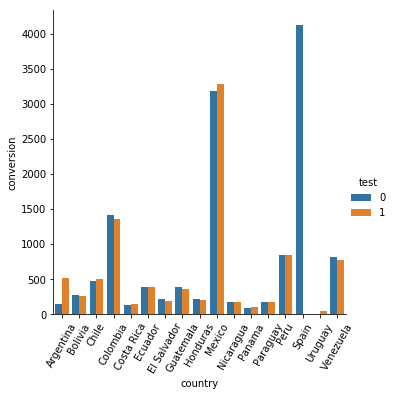

In [186]:
# Plotting
import seaborn as sns
print (sns.__version__)
g = sns.catplot(x = "country", y = "conversion", hue = 'test',
                data = dat[['country','test','conversion']].groupby(['country','test'],as_index = False).agg({'conversion': 'sum'}), 
                kind="bar")
g.set_xticklabels(rotation = 60)

We realize that Spain should not be in the A/B test since the condition is no different to this country.

So we decide that:
- Remove all Nan values
- Remove Spain out of the data
- Remove all langues except Spanish

In [187]:
dat_test = dat[(dat['country'] != 'Spain')]
dat_test = dat_test[(dat_test['browser_language'] == 'ES')]
dat_test = dat_test.dropna()


In [188]:
dat_test.head()

user_id        date source  device browser_language ads_channel  \
1    497851  2015-12-04    Ads     Web               ES      Google   
4    548435  2015-11-30    Ads     Web               ES      Google   
9     10427  2015-12-04    Ads  Mobile               ES    Facebook   
10     8343  2015-11-30    Ads  Mobile               ES        Bing   
14   207018  2015-12-03    Ads     Web               ES      Google   

        browser  conversion  test sex   age   country  
1            IE           0     1   M  21.0    Mexico  
4       FireFox           0     1   M  19.0    Mexico  
9   Android_App           0     0   F  33.0    Mexico  
10  Android_App           1     0   M  37.0  Colombia  
14       Chrome           0     0   F  28.0    Mexico

0.9.0


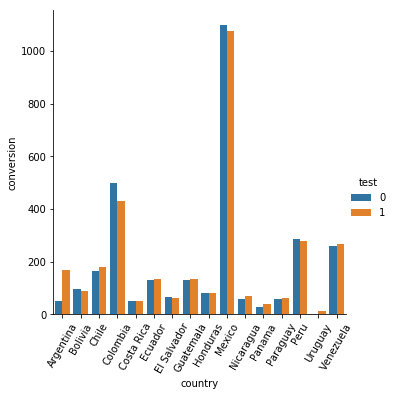

In [189]:
# Plotting
import seaborn as sns
print (sns.__version__)
g = sns.catplot(x = "country", y = "conversion", hue = 'test',
                data = dat_test[['country','test','conversion']].groupby(['country','test'],as_index = False).agg({'conversion': 'sum'}), 
                kind="bar")
g.set_xticklabels(rotation = 60)

# Part 1: Confirm that the test is actually negative.
- That is, it appears that the old version of the site with just one translation across Spain and LatAm performs better.
- To do so, we use the proportion test to check whether the conversation percentage in two groups (test vs nontest) is statistically different.


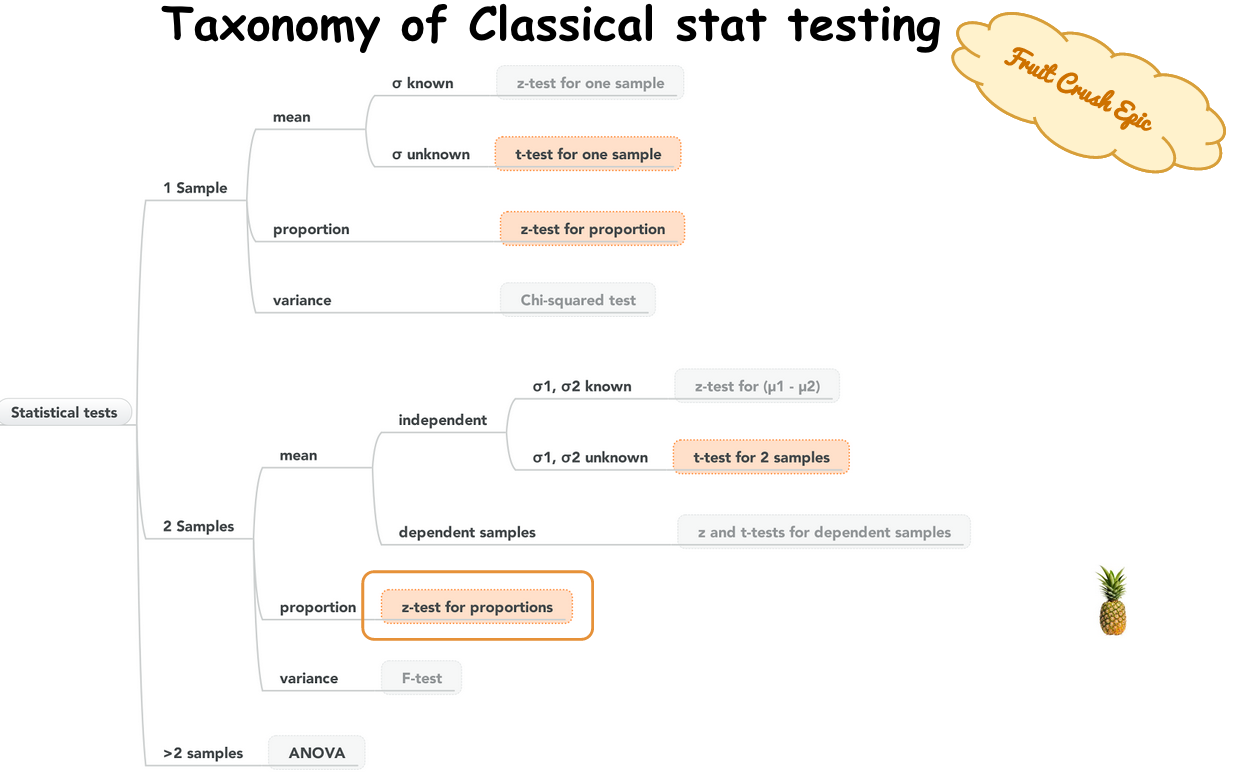

In [190]:
from IPython.display import Image
Image('https://cloud.githubusercontent.com/assets/5244286/7023317/3e8c68c8-dd2c-11e4-8735-51edd4b8bfcb.png', retina=True)

In [191]:
from statsmodels.stats.proportion import proportions_ztest
count = np.array([dat_test[dat_test.test == 0]['conversion'].sum(),dat_test[dat_test.test == 1]['conversion'].sum()])
nobs = np.array([dat_test[dat_test.test == 0]['conversion'].count(), dat_test[dat_test.test == 1]['conversion'].count()])
z,p = proportions_ztest(count, nobs, value=0, alternative='two-sided')
print(' z-stat = {z} \n p-value = {p}'.format(z=z,p=p))

 z-stat = 4.95542582440162 
 p-value = 7.217205223024738e-07


We can reject the null-hypothesis which is there is no difference between the rate in control group and in test group. Z-score is larger than 0, the control group has more conversation rate than the test group, which implied the test has negative effects.

# Part 2: Explain why the result might be happening. 
Are the localized translations really worse?

There might be an anomaly in data set. To detech it we use decision tree to see which feature is the most important.

In [192]:
dat_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133871 entries, 1 to 453320
Data columns (total 12 columns):
user_id             133871 non-null int64
date                133871 non-null object
source              133871 non-null object
device              133871 non-null object
browser_language    133871 non-null object
ads_channel         133871 non-null object
browser             133871 non-null object
conversion          133871 non-null int64
test                133871 non-null int64
sex                 133871 non-null object
age                 133871 non-null float64
country             133871 non-null object
dtypes: float64(1), int64(3), object(8)
memory usage: 13.3+ MB


## Check the date

In [193]:
dat_test['date'] = pd.to_datetime(dat_test.date)
# The day of the week with Monday=0, Sunday=6
dat_test['weekday'] = dat_test.date.dt.weekday
dat_test['weekday'] = dat_test.weekday.astype('str')

df_tree1 = dat_test[['weekday', 'conversion', 'test']]

In [194]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets
from IPython.display import Image  
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [195]:
y = df_tree1['conversion']
X = df_tree1.drop(['conversion'],axis=1).copy()
X = pd.get_dummies(X, columns=['weekday'])
dtree = DecisionTreeClassifier(criterion = "entropy", random_state = 100, 
            max_depth = None, min_samples_leaf = 5)
dtree.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

Feature ranking:
1. test (0.758345)
2. weekday_4 (0.172167)
3. weekday_2 (0.039494)
4. weekday_0 (0.022545)
5. weekday_1 (0.007287)
6. weekday_3 (0.000161)


Text(0.5,0,'Relative Importance')

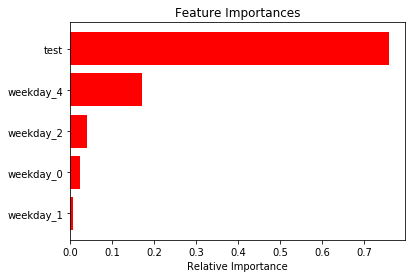

In [196]:
dtree = DecisionTreeClassifier(criterion = "entropy", random_state = 100, 
            max_depth = None, min_samples_leaf = 5)
dtree.fit(X,y)

features = X.columns
importances = dtree.feature_importances_
nSelectedFeature = 6
indices = np.argsort(importances)[-(nSelectedFeature-1):]

# Print the feature ranking
rank = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(nSelectedFeature):
    print("%d. %s (%f)" % (f + 1, features[rank[f]] , importances[rank[f]]))


# Bar plot
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

## Check the Device

In [197]:
dat_test.columns

Index(['user_id', 'date', 'source', 'device', 'browser_language',
       'ads_channel', 'browser', 'conversion', 'test', 'sex', 'age', 'country',
       'weekday'],
      dtype='object')

Feature ranking:
1. test (0.931387)
2. device_Web (0.068613)
3. device_Mobile (0.000000)


Text(0.5,0,'Relative Importance')

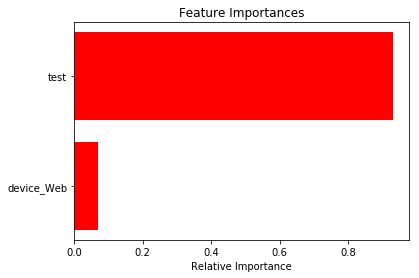

In [198]:
df_tree2 = dat_test[['device', 'conversion', 'test']] 

y = df_tree2['conversion']
X = df_tree2.drop(['conversion'],axis=1).copy()
X = pd.get_dummies(X, columns=['device'])
dtree = DecisionTreeClassifier(criterion = "entropy", random_state = 100, 
            max_depth = None, min_samples_leaf = 5)
dtree.fit(X,y)

dtree = DecisionTreeClassifier(criterion = "entropy", random_state = 100, 
            max_depth = None, min_samples_leaf = 5)
dtree.fit(X,y)

features = X.columns
importances = dtree.feature_importances_
nSelectedFeature = 3
indices = np.argsort(importances)[-(nSelectedFeature-1):]

# Print the feature ranking
rank = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(nSelectedFeature):
    print("%d. %s (%f)" % (f + 1, features[rank[f]] , importances[rank[f]]))


# Bar plot
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

## Ads Channel

Feature ranking:
1. test (0.781670)
2. ads_channel_Facebook (0.113356)
3. ads_channel_Bing (0.052096)
4. ads_channel_Other (0.050858)
5. ads_channel_Yahoo (0.002021)
6. ads_channel_Google (0.000000)


Text(0.5,0,'Relative Importance')

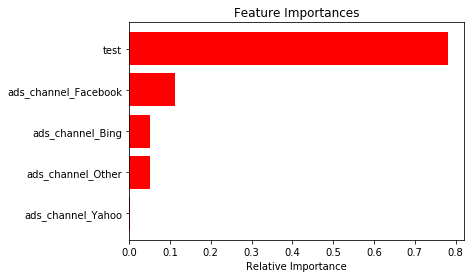

In [199]:
df_tree3 = dat_test[['ads_channel', 'conversion', 'test']] 

y = df_tree3['conversion']
X = df_tree3.drop(['conversion'],axis=1).copy()
X = pd.get_dummies(X, columns=['ads_channel'])
dtree = DecisionTreeClassifier(criterion = "entropy", random_state = 100, 
            max_depth = None, min_samples_leaf = 5)
dtree.fit(X,y)

dtree = DecisionTreeClassifier(criterion = "entropy", random_state = 100, 
            max_depth = None, min_samples_leaf = 5)
dtree.fit(X,y)

features = X.columns
importances = dtree.feature_importances_
nSelectedFeature = 6
indices = np.argsort(importances)[-(nSelectedFeature-1):]

# Print the feature ranking
rank = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(nSelectedFeature):
    print("%d. %s (%f)" % (f + 1, features[rank[f]] , importances[rank[f]]))


# Bar plot
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

## Browser

Feature ranking:
1. test (0.665133)
2. browser_Opera (0.206590)
3. browser_Android_App (0.044441)
4. browser_IE (0.035861)
5. browser_Iphone_App (0.028356)
6. browser_Safari (0.011686)
7. browser_FireFox (0.005086)
8. browser_Chrome (0.002848)


Text(0.5,0,'Relative Importance')

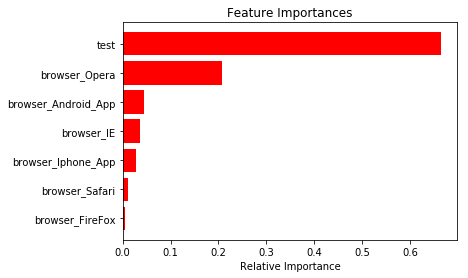

In [200]:
df_tree4 = dat_test[['browser', 'conversion', 'test']] 

y = df_tree4['conversion']
X = df_tree4.drop(['conversion'],axis=1).copy()
X = pd.get_dummies(X, columns=['browser'])
dtree = DecisionTreeClassifier(criterion = "entropy", random_state = 100, 
            max_depth = None, min_samples_leaf = 5)
dtree.fit(X,y)

dtree = DecisionTreeClassifier(criterion = "entropy", random_state = 100, 
            max_depth = None, min_samples_leaf = 5)
dtree.fit(X,y)

features = X.columns
importances = dtree.feature_importances_
nSelectedFeature = 8
indices = np.argsort(importances)[-(nSelectedFeature-1):]

# Print the feature ranking
rank = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(nSelectedFeature):
    print("%d. %s (%f)" % (f + 1, features[rank[f]] , importances[rank[f]]))


# Bar plot
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

## Sex

Feature ranking:
1. test (0.969076)
2. sex_M (0.030924)
3. sex_F (0.000000)


Text(0.5,0,'Relative Importance')

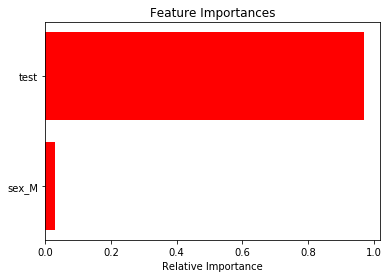

In [201]:
df_tree5 = dat_test[['sex', 'conversion', 'test']] 

y = df_tree5['conversion']
X = df_tree5.drop(['conversion'],axis=1).copy()
X = pd.get_dummies(X, columns=['sex'])
dtree = DecisionTreeClassifier(criterion = "entropy", random_state = 100, 
            max_depth = None, min_samples_leaf = 5)
dtree.fit(X,y)

dtree = DecisionTreeClassifier(criterion = "entropy", random_state = 100, 
            max_depth = None, min_samples_leaf = 5)
dtree.fit(X,y)

features = X.columns
importances = dtree.feature_importances_
nSelectedFeature = 3
indices = np.argsort(importances)[-(nSelectedFeature-1):]

# Print the feature ranking
rank = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(nSelectedFeature):
    print("%d. %s (%f)" % (f + 1, features[rank[f]] , importances[rank[f]]))


# Bar plot
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')


## Country

Feature ranking:
1. country_Argentina (0.855162)
2. country_Uruguay (0.107329)
3. test (0.020714)
4. country_Nicaragua (0.003201)
5. country_Costa Rica (0.002521)
6. country_Honduras (0.002428)
7. country_Ecuador (0.002415)
8. country_Colombia (0.002116)
9. country_El Salvador (0.001350)
10. country_Venezuela (0.000881)
11. country_Guatemala (0.000740)
12. country_Chile (0.000384)
13. country_Bolivia (0.000284)
14. country_Paraguay (0.000272)
15. country_Panama (0.000202)
16. country_Mexico (0.000000)
17. country_Peru (0.000000)


Text(0.5,0,'Relative Importance')

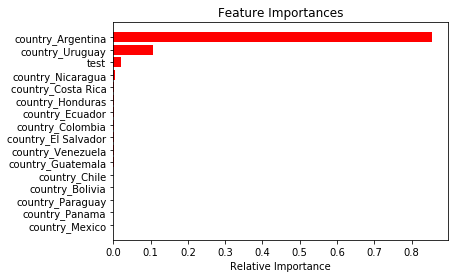

In [202]:
df_tree5 = dat_test[['country', 'conversion', 'test']] 

y = df_tree5['conversion']
X = df_tree5.drop(['conversion'],axis=1).copy()
X = pd.get_dummies(X, columns=['country'])
dtree = DecisionTreeClassifier(criterion = "entropy", random_state = 100, 
            max_depth = None, min_samples_leaf = 5)
dtree.fit(X,y)

dtree = DecisionTreeClassifier(criterion = "entropy", random_state = 100, 
            max_depth = None, min_samples_leaf = 5)
dtree.fit(X,y)

features = X.columns
importances = dtree.feature_importances_
nSelectedFeature = 17
indices = np.argsort(importances)[-(nSelectedFeature-1):]

# Print the feature ranking
rank = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(nSelectedFeature):
    print("%d. %s (%f)" % (f + 1, features[rank[f]] , importances[rank[f]]))


# Bar plot
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

## Weekday

Feature ranking:
1. test (0.758345)
2. weekday_4 (0.172167)
3. weekday_2 (0.039494)
4. weekday_0 (0.022545)
5. weekday_1 (0.007287)
6. weekday_3 (0.000161)


Text(0.5,0,'Relative Importance')

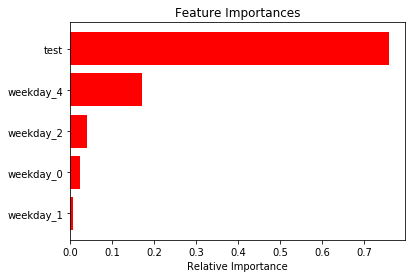

In [203]:
df_tree6 = dat_test[['weekday', 'conversion', 'test']] 

y = df_tree6['conversion']
X = df_tree6.drop(['conversion'],axis=1).copy()
X = pd.get_dummies(X, columns=['weekday'])
dtree = DecisionTreeClassifier(criterion = "entropy", random_state = 100, 
            max_depth = None, min_samples_leaf = 5)
dtree.fit(X,y)

dtree = DecisionTreeClassifier(criterion = "entropy", random_state = 100, 
            max_depth = None, min_samples_leaf = 5)
dtree.fit(X,y)

features = X.columns
importances = dtree.feature_importances_
nSelectedFeature = 6
indices = np.argsort(importances)[-(nSelectedFeature-1):]

# Print the feature ranking
rank = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(nSelectedFeature):
    print("%d. %s (%f)" % (f + 1, features[rank[f]] , importances[rank[f]]))


# Bar plot
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

## Age

Feature ranking:
1. age (0.803176)
2. test (0.196824)


Text(0.5,0,'Relative Importance')

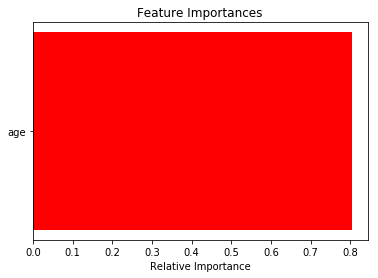

In [204]:
df_tree7 = dat_test[['age', 'conversion', 'test']] 

y = df_tree7['conversion']
X = df_tree7.drop(['conversion'],axis=1).copy()
X = pd.get_dummies(X)
dtree = DecisionTreeClassifier(criterion = "entropy", random_state = 100, 
            max_depth = None, min_samples_leaf = 5)
dtree.fit(X,y)

dtree = DecisionTreeClassifier(criterion = "entropy", random_state = 100, 
            max_depth = None, min_samples_leaf = 5)
dtree.fit(X,y)

features = X.columns
importances = dtree.feature_importances_
nSelectedFeature = 2
indices = np.argsort(importances)[-(nSelectedFeature-1):]

# Print the feature ranking
rank = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(nSelectedFeature):
    print("%d. %s (%f)" % (f + 1, features[rank[f]] , importances[rank[f]]))


# Bar plot
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

We notice that only the feature **country** (especially _Argentina and Uruguay_) and **age** has bigger effects than **test** to the results of **conversation**. This means that if there is an anomally, it should be in these features. 

## Take a deeper look on Age

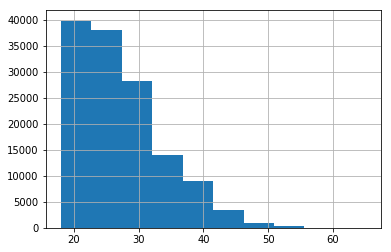

In [205]:
dat_test.age.hist()

In [206]:
dat_test.groupby(['test', 'conversion'])['age'].mean().to_frame()

age
test conversion           
0    0           27.143104
     1           27.082241
1    0           27.112135
     1           27.008323

Everything seems to be right with the age of user. Normally young people talk more online and the distribution of age between control/test group seems alright.

## Take a deeper look on Country, especially Argentina and Uruguay

In [207]:
dat_test.groupby(['country', 'test'])['conversion'].size().to_frame()

conversion
country     test            
Argentina   0           3118
            1          12502
Bolivia     0           1905
            1           1854
Chile       0           3327
            1           3298
Colombia    0           9012
            1           8779
Costa Rica  0            874
            1            882
Ecuador     0           2733
            1           2470
El Salvador 0           1395
            1           1323
Guatemala   0           2562
            1           2527
Honduras    0           1490
            1           1397
Mexico      0          21472
            1          21674
Nicaragua   0           1148
            1           1072
Panama      0            628
            1            662
Paraguay    0           1214
            1           1257
Peru        0           5564
            1           5589
Uruguay     0            136
            1           1248
Venezuela   0           5466
            1           5293

We easily see that the number of user in the test group and control group is not balance in Argentina and Uruguay as it is the case in other countries. There are way more people in the test group than in control group. Therefore the results in test groups of these two countries might affect the whole test.

# Part 3: Design an algorithm to detect the same problem.
It would return FALSE if the same problem is happening in the future and TRUE if everything is good and the results can be trusted.

So our problem is the unblanced size between control group and test group in each country.

In [208]:
def check_validity (data):
    # Create dataset:
    dat_check = data.groupby(['country', 'test'])['conversion'].size().to_frame()
    sum = data.groupby('country')['conversion'].size().to_frame()
    
    # We join the two tables by country.
    check = pd.merge(dat_check, sum, how = 'outer', on = 'country')
    
    check['ratio'] = check.conversion_x/check.conversion_y
    
    # We accept the ration between control group and test group is 0.45-0.55
    
    in_between = all((check.ratio <= 0.55) & (check.ratio >= 0.45))
    
    return in_between

In [209]:
check_validity(dat)

False